In [1]:
import sys
import os

# Go two levels up: src/preprocessing → src → VOICE_EMOTION_RECOGNITION (project root)
print(f"os.getcwd(): {os.getcwd()}")
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)

os.getcwd(): d:\voice_emotion_recognition\src\preprocessing
Project root: d:\voice_emotion_recognition


In [2]:
os.getcwd()  # Ensure the current working directory is set correctly

'd:\\voice_emotion_recognition\\src\\preprocessing'

In [3]:
import shutil
shutil.rmtree("../../src/utils/__pycache__")



In [4]:
import sys
import importlib

if "src.utils.augment" in sys.modules:
    del sys.modules["src.utils.augment"]

import src.utils.augment as augment
importlib.reload(augment)



<module 'src.utils.augment' from 'd:\\voice_emotion_recognition\\src\\utils\\augment.py'>

In [5]:
from src.utils.augment import (
    augment_add_noise,
    augment_time_stretch,
    augment_pitch_shift,
)


In [6]:
import inspect
print(inspect.getsource(augment_time_stretch))
print(inspect.getsource(augment_pitch_shift))
print(inspect.getsource(augment_add_noise))

def augment_time_stretch(audio, rate=0.8):
    """
    Time-stretch the audio by a given rate (e.g., 0.8 = slow down, 1.2 = speed up).

    Args:
        audio (np.ndarray): Input waveform.
        rate (float): Stretch factor.

    Returns:
        np.ndarray: Time-stretched audio.
    """
    return librosa.effects.time_stretch(y=audio, rate=rate)

def augment_pitch_shift(audio, sr, n_steps=2):
    """
    Shift the pitch of the audio.

    Args:
        audio (np.ndarray): Input waveform.
        sr (int): Sampling rate.
        n_steps (int): Steps to shift pitch (positive or negative).

    Returns:
        np.ndarray: Pitch-shifted audio.
    """
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

def augment_add_noise(audio, noise_factor=0.005):
    """
    Add Gaussian noise to the audio.

    Args:
        audio (np.ndarray): Input waveform.
        noise_factor (float): Scale of added noise.

    Returns:
        np.ndarray: Noisy audio.
    """
    noise

In [7]:
import os
import librosa
import numpy as np
import random
# from src.utils.augment import add_noise, time_stretch, pitch_shift


In [8]:

emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}


In [9]:
# Feature extraction
def extract_logmel(audio, sr, n_mels=128, max_len=173):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel, ref=np.max)
    logmel = librosa.util.fix_length(logmel, size=max_len, axis=1)
    logmel = (logmel - logmel.min()) / (logmel.max() - logmel.min() + 1e-6)
    return logmel

In [10]:
# Data loading + augmentation
def load_data(data_dir, n_mels=128, max_len=173):
    X, y = [], []
    print(f"Scanning: {data_dir}")

    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                try:
                    emotion_id = file.split("-")[2]
                    emotion = emotion_map.get(emotion_id)
                    if not emotion:
                        continue

                    audio, sr = librosa.load(file_path, res_type='kaiser_fast')
                    features = extract_logmel(audio, sr, n_mels, max_len)
                    X.append(features[..., np.newaxis])
                    y.append(emotion)

                    # Data augmentation
                    aug_type = random.choice(['noise', 'stretch', 'pitch'])
                    if aug_type == 'noise':
                        aug_audio = augment_add_noise(audio)
                    elif aug_type == 'stretch':
                        aug_audio = augment_time_stretch(audio, rate=0.8)
                    else:
                        aug_audio = augment_pitch_shift(audio, sr, n_steps=2)

                    aug_features = extract_logmel(aug_audio, sr, n_mels, max_len)
                    X.append(aug_features[..., np.newaxis])
                    y.append(emotion)

                except Exception as e:
                    print(f"Skipping {file} due to error: {e}")

    return np.array(X), np.array(y)

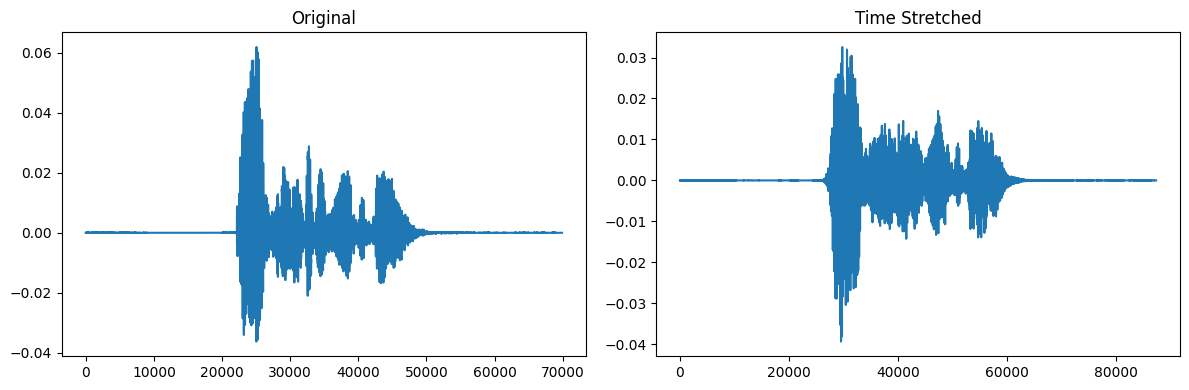

In [11]:
from src.utils.augment import apply_all_augmentations
import librosa
import matplotlib.pyplot as plt

audio, sr = librosa.load("../../data/raw/ravdess/Actor_01/03-01-01-01-02-02-01.wav")
augmented = apply_all_augmentations(audio, sr)

# Visualizing original vs stretch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.plot(augmented['original'])

plt.subplot(1, 2, 2)
plt.title("Time Stretched")
plt.plot(augmented['stretch'])
plt.tight_layout()
plt.show()


In [12]:
# audio, sr = librosa.load("../../data/raw/ravdess/Actor_01/03-01-01-01-02-02-01.wav")
# aug = augment_time_stretch(audio, sr=sr, rate=0.8)
# print("Success:", aug.shape)


In [13]:

if __name__ == "__main__":
    data_path = "../../data/raw/ravdess/"
    X, y = load_data(data_path)
    print("Final shape:", X.shape)  # (samples, 128, 173, 1)
    print("Labels shape:", y.shape)


Scanning: ../../data/raw/ravdess/
Final shape: (2880, 128, 173, 1)
Labels shape: (2880,)


In [15]:
np.save("../../data/features/features_v5.npy", X)
np.save("../../data/features/labels_v5.npy", y)


# Class distribution after pre-process + data aug

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# Load labels
labels = np.load("../../data/features/labels_v5.npy")

# Count label frequencies
label_counts = Counter(labels)
classes = list(label_counts.keys())
counts = list(label_counts.values())


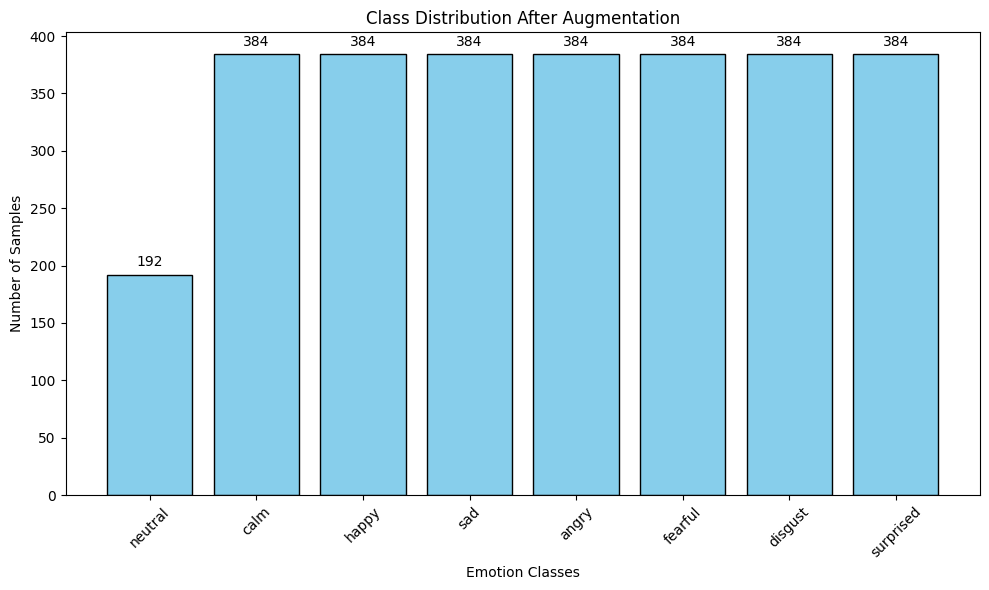

In [18]:

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After Augmentation")

# Add counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
